In [ ]:
# !pip install kaggle pandas tensorflow

   ---------------------------------------- 0.0/181.2 kB ? eta -:--:--
   --------------------------------- ------ 153.6/181.2 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 181.2/181.2 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/163.4 kB ? eta -:--:--
   ---------------------------------------- 163.4/163.4 kB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.2 kB ? eta -:--:--
   ---------------------------------------- 78.2/78.2 kB 4.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\max77\.kaggle'
import shutil
import pandas as pd
from tqdm import tqdm

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Télécharger le dataset CelebA
api.dataset_download_files('jessicali9530/celeba-dataset', path='celeba_image', unzip=True)

# Chemins
base_dir = 'celeba_image'
img_dir = os.path.join(base_dir, 'img_align_celeba', 'img_align_celeba')
attr_file = os.path.join(base_dir, 'list_attr_celeba.csv')
output_dir = os.path.join(base_dir, 'smile_split')

NUM_SAMPLES = 25000  # ← Modifie ici pour plus/moins

# Lire les attributs
df = pd.read_csv(attr_file)
df.set_index('image_id', inplace=True)

df_sampled = df.sample(n=NUM_SAMPLES, random_state=0)

# Créer les dossiers
os.makedirs(os.path.join(output_dir, 'smiling'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'not_smiling'), exist_ok=True)

# Copier les images dans les bons dossiers
for img_name, row in tqdm(df.iterrows(), total=len(df)):
    smile = row['Smiling']
    src_path = os.path.join(img_dir, img_name)
    if not os.path.exists(src_path):
        continue

    if smile == 1:
        dst_path = os.path.join(output_dir, 'smiling', img_name)
    else:
        dst_path = os.path.join(output_dir, 'not_smiling', img_name)

    shutil.copy(src_path, dst_path)

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


100%|██████████| 202599/202599 [07:14<00:00, 466.20it/s]


In [5]:
import random
from pathlib import Path
# === CONFIGURATION ===
source_dir = 'celeba_image/smile_split'  # dossier où les images sont déjà triées (smiling / not_smiling)
output_dir = 'celeba_sampled'  # dossier de sortie pour le sous-groupe
samples_per_class = 2500       # nombre d’images à prélever par classe  2500+2500 donc 5000 au total
image_size = (256, 256)        # taille d’image
batch_size = 32
seed = 0

# === ÉTAPES ===

# Crée les dossiers de sortie
for class_name in ['smiling', 'not_smiling']:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Pour chaque classe, sélectionner un échantillon aléatoire
for class_name in ['smiling', 'not_smiling']:
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    sampled = random.sample(images, samples_per_class)

    for img in sampled:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, class_name, img)
        shutil.copy(src, dst)

print("✅ Images copiées avec succès.")

✅ Images copiées avec succès.


In [6]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir,
    validation_split=0.2,   # 80% pour l'entrainement
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir,
    validation_split=0.2,   # 20% pour la validation
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # 📌 Callback pour arrêter tôt si la val_loss stagne
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=2,           # nb d'époques sans amélioration avant arrêt
#     restore_best_weights=True
# )

# # 📌 Callback pour réduire le learning rate si la val_loss stagne
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-6
# )

# # 📌 (Optionnel) Sauvegarder le meilleur modèle selon val_loss
# model_checkpoint = ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_loss',
#     save_best_only=True
# )

In [ ]:
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Input(shape=(256, 256, 3)),
#     layers.Rescaling(1./255),
#     layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same',),
#     # BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'),
#     # BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
#     # BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     # layers.Dense(128, activation='relu'),
#     # layers.Dropout(0,1),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0,1),
#     layers.Dense(1, activation='sigmoid')   # 0 = not_smiling / 1 = smiling
# ])

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # === ENTRAÎNEMENT ===
# history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping, reduce_lr, model_checkpoint])

NameError: name 'BatchNormalization' is not defined

In [ ]:
# !pip install seaborn 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 5000 files belonging to 2 classes.
Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.4958 - loss: 0.6975 - val_accuracy: 0.5917 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.5151 - loss: 0.6932 - val_accuracy: 0.4854 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.5312 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.6020 - loss: 0.6661 - val_accuracy: 0.6812 - val_loss: 0.6245 - learning_rate: 0.0010
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.6948 - loss: 0.5967 - val_accuracy: 0.7688 - val_loss: 0.5396 - learning_rate: 0.0010
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.8089 - loss: 0.4247 - val_accuracy: 0.8500 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 7/30
127/127 ━━━━━━━━━━

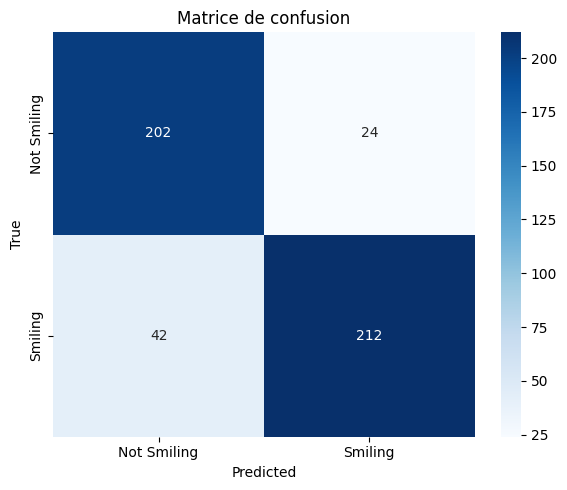

In [27]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Charger toutes les images depuis le dossier
full_ds = tf.keras.utils.image_dataset_from_directory(
    'celeba_sampled',  # <-- change ce chemin si besoin
    image_size=(128, 128),
    batch_size=32,
    seed=0,
    label_mode='binary'
)

# === 2. Split en train, val, test
total_size = full_ds.cardinality().numpy()
test_size = total_size // 10
val_size = total_size // 10
train_size = total_size - test_size - val_size

test_ds = full_ds.take(test_size)
val_ds = full_ds.skip(test_size).take(val_size)
train_ds = full_ds.skip(test_size + val_size)

# === 3. Prétraitement (normalisation)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# === 4. Définir le modèle CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=(128, 128, 3)),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 5. Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=0.001)
]

# === 6. Entraîner le modèle
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

# === 7. Évaluer sur test_ds
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true).astype(int).flatten()
y_pred = np.array(y_pred).astype(int).flatten()

# === 8. Rapport de classification
print("\n🧪 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=['Not Smiling', 'Smiling']))

# === 9. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Smiling', 'Smiling'],
            yticklabels=['Not Smiling', 'Smiling'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()


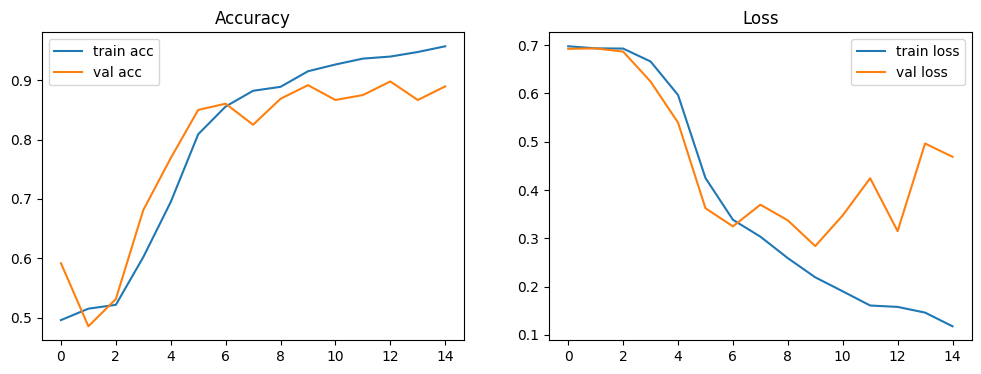

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()